In [1]:
from dotenv import load_dotenv
import os

load_dotenv()  # Load variables from .env
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [9]:
# Import Langchain modules
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema.messages import HumanMessage


In [4]:
llm = ChatOpenAI(model="gpt-4o-mini", api_key=OPENAI_API_KEY)

In [6]:

PROMPT_TEMPLATE = """
You are an expert PDF OCR and markdown conversion assistant.
Given an image of full page scanned {language} textbook:
1. Perform full OCR processing
2. Preserve original document structure
3. Convert to clean markdown
4. Maintain:
   - Original formatting
   - Section hierarchies
   - Typography distinctions
   - Tables and lists
5. Clean up OCR artifacts
6. Ensure maximum text accuracy
7. Handle multi-column layouts intelligently
8. Detect and properly format headers, paragraphs, captions

Output requirements:
- Fully searchable markdown file
- Professional formatting
- No OCR noise/errors
- Semantic markdown structure
- Readable and well-organized
"""

prompt=PROMPT_TEMPLATE.format(language="spanish")

In [7]:
import base64
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

In [8]:
encoded_image = encode_image("data/ai1p103.jpeg")

HumanMessage(content=[{'type': 'text', 'text': '\nYou are an expert PDF OCR and markdown conversion assistant.\nGiven an image of full page scanned spanish textbook:\n1. Perform full OCR processing\n2. Preserve original document structure\n3. Convert to clean markdown\n4. Maintain:\n   - Original formatting\n   - Section hierarchies\n   - Typography distinctions\n   - Tables and lists\n5. Clean up OCR artifacts\n6. Ensure maximum text accuracy\n7. Handle multi-column layouts intelligently\n8. Detect and properly format headers, paragraphs, captions\n\nOutput requirements:\n- Fully searchable markdown file\n- Professional formatting\n- No OCR noise/errors\n- Semantic markdown structure\n- Readable and well-organized\n'}, {'type': 'image_url', 'image_url': {'url': ''}}], additional_kwargs={}, response_metadata={})
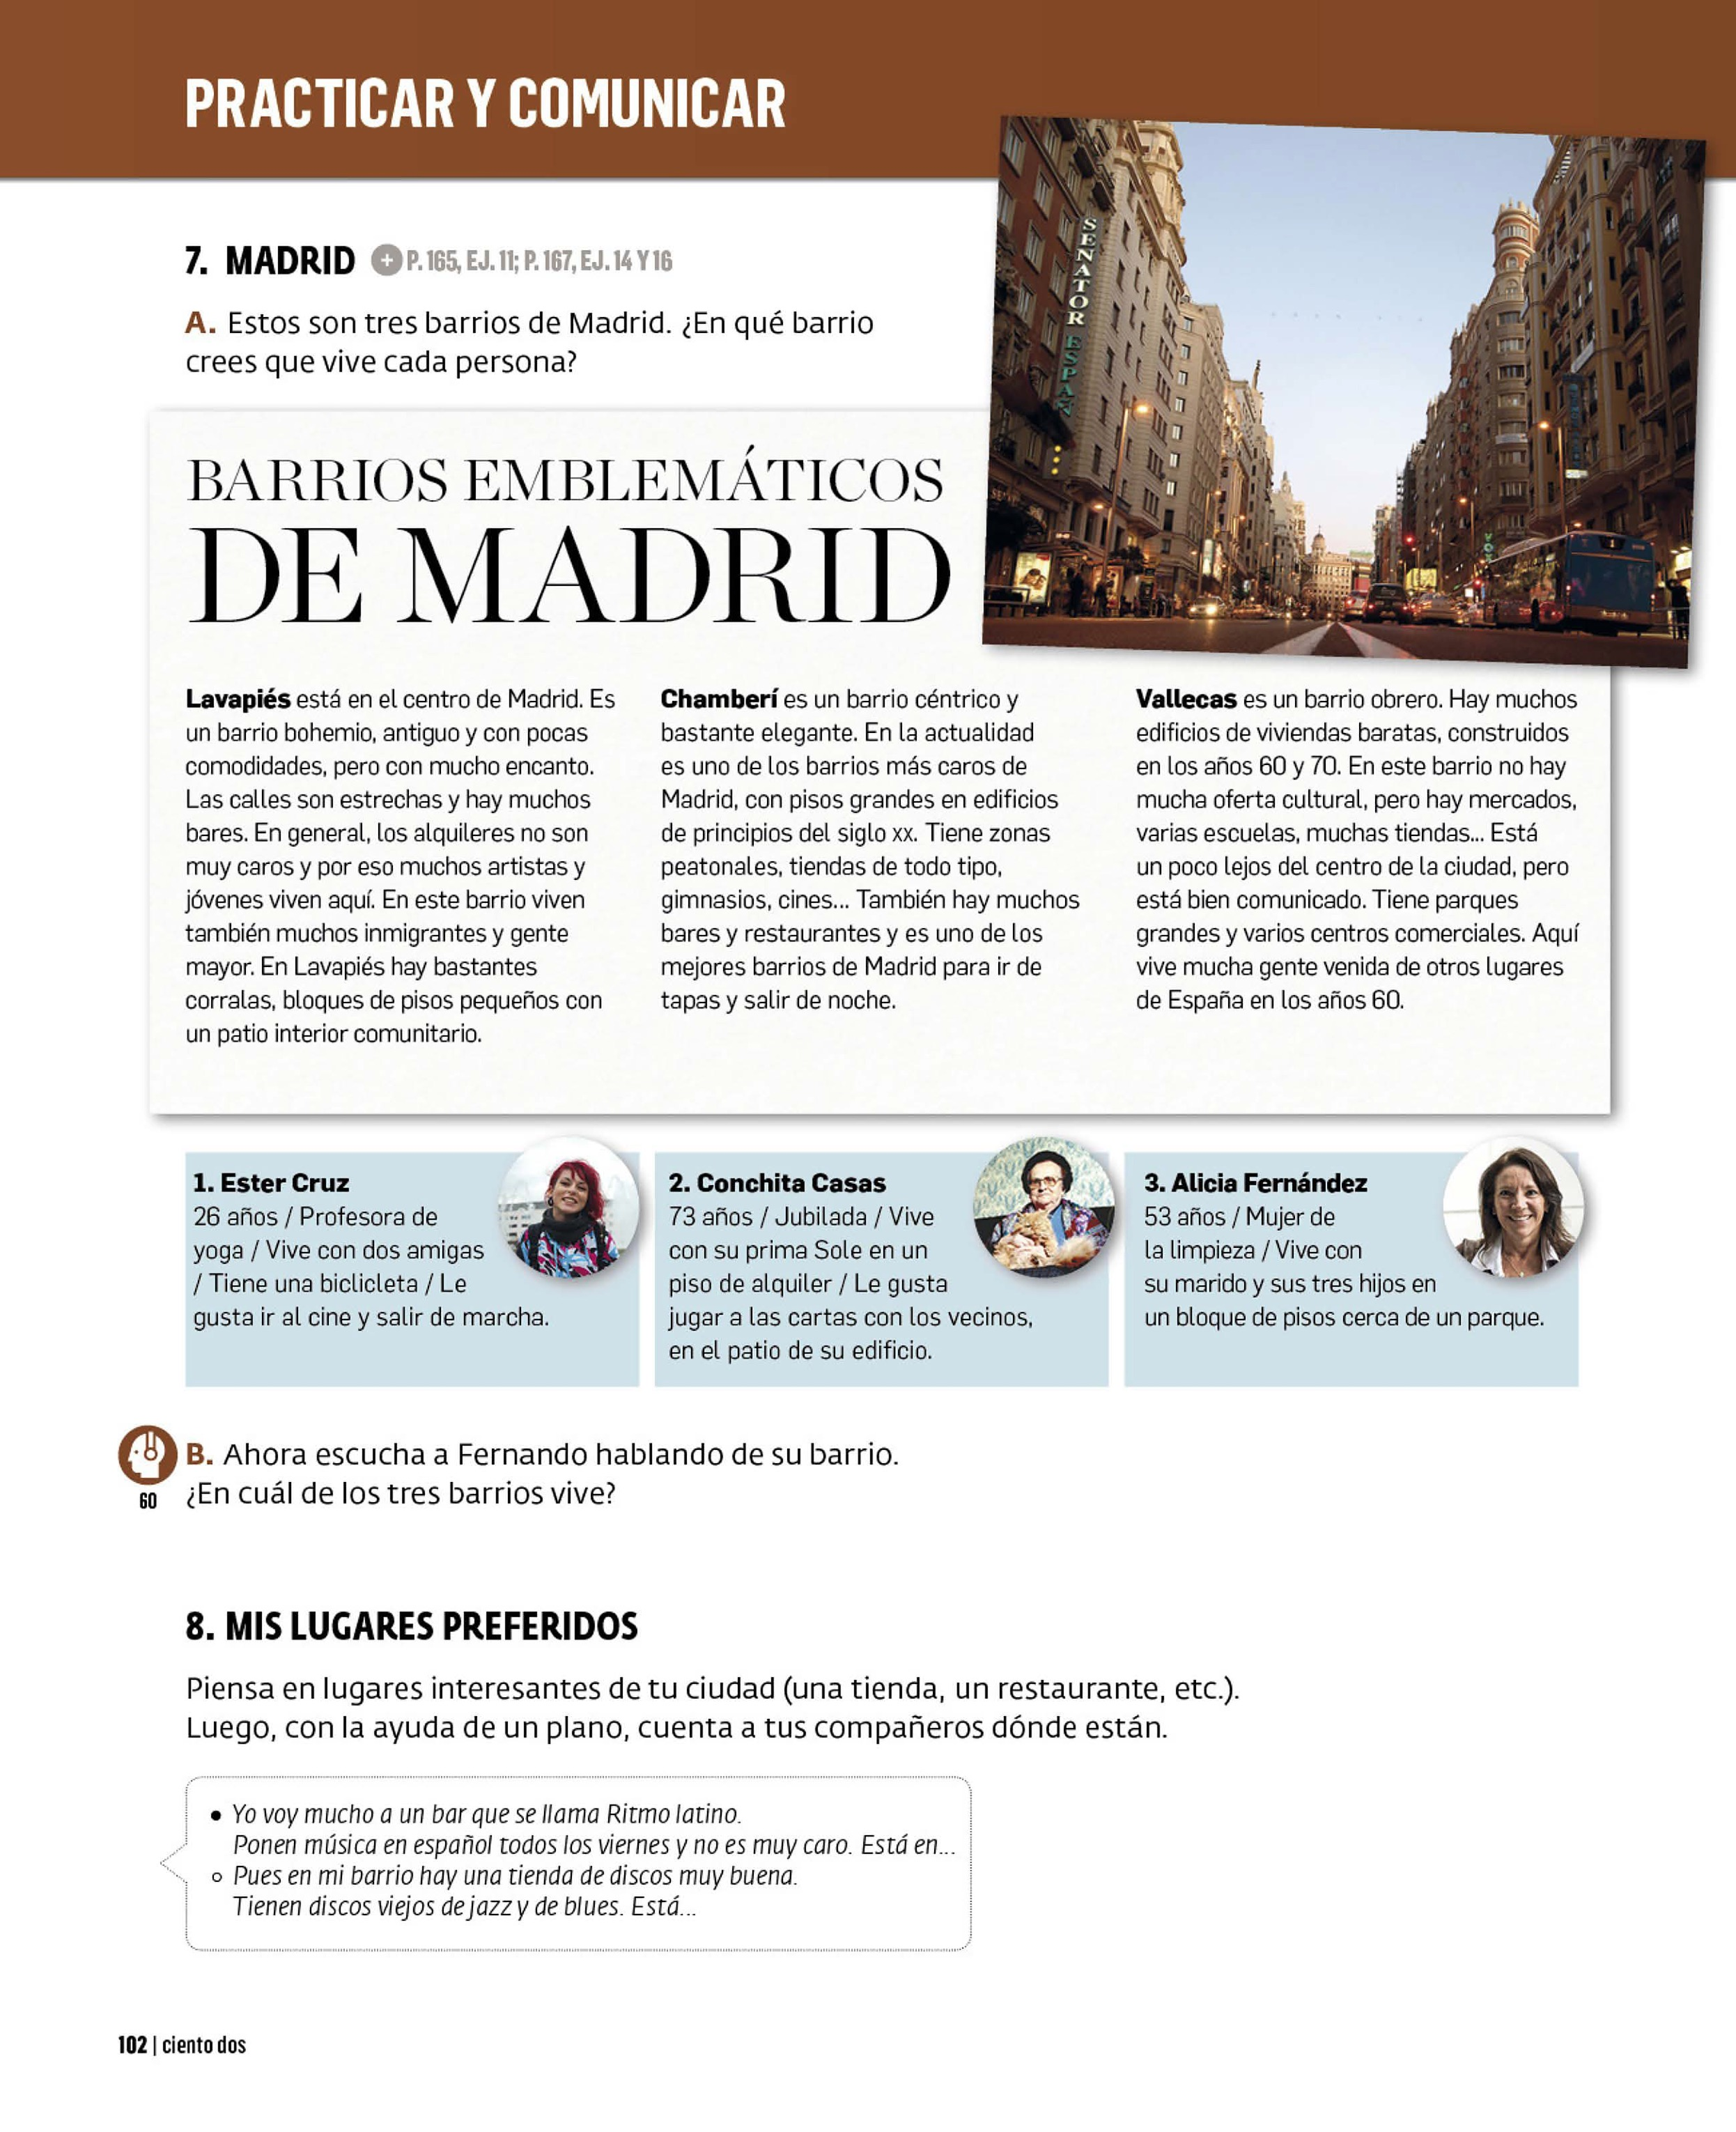

In [10]:
def create_image_message(instruction,encoded_image):
    message = HumanMessage(
        content=[
            {"type": "text", "text": instruction}, # Use the dynamic instruction
            {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{encoded_image}"}},
        ]
    )
    return message

hm=create_image_message(prompt,encoded_image)
hm

In [11]:
response=llm.invoke([hm])

In [12]:
def save_as_markdown(content, file_path):
    """
    Saves the given content as a markdown file after trimming the first and last lines.

    Args:
        content (str): The content to be saved.
        file_path (str): The path where the markdown file will be saved.

    Returns:
        None
    """
    lines = content.split('\n')
    trimmed_content = '\n'.join(lines[1:-2])
    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(trimmed_content)

# Example usage
markdown_content = response.content
file_path = 'output2.md'
save_as_markdown(markdown_content, file_path)